problem set up

want to solve pde :

du/dx = 2du/dt + u, with boundary condition is u(x,0) = 6e^(-3x)

independen variables : x,t. so u = u(x,t)

dependent variables is u(output)

x in range [0,2] and t in range[0,1]

"""let's do it with PINN"""

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
print(device)

cuda:0


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import numpy as np

In [4]:
"""

want to create a PINN network with 5 hidden layers with 5 neurons each.
and it should get 2 input part and 1 output part

"""

class Net(nn.Module) :
    def __init__(self) :
        super(Net,self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)
        
        
    def forward(self,x,t) :
        inputs = torch.cat([x,t],axis =1 ) # torch.cat is just for change dimension to good dimensions
        #. since information is given as x,t two arrays of 1 cloumns, need to be changed to 2 colmuns since self.hidden_layer1 is nn.Linear(2,5) form
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) # since output, there is no sigmoid function(no activation function)
        return output
    
    

        

In [5]:

net = Net() # is what we defined and stands for net.
net = net.to(device) #is to send net calculation to device
mse_cos_function = torch.nn.MSELoss() #is mean squared error loss function
optimizer = torch.optim.Adam(net.parameters()) # is for optimizer name Adam for parameters in our model.


In [6]:
#define pde as loss function(pinn has two loss function)

def f(x,t,net) :
    u = net(x,t) # is to let u is given by the network based on independent variables x,t. so we need u_t and u_x
    #define u_t and u_x
    
    u_x = torch.autograd.grad(u.sum(),x,create_graph=True)[0] # sum is for when x is tensor, and reduces it to a scalar,allowing to be calculated. since vector can't be cal
    u_t = torch.autograd.grad(u.sum(),t,create_graph=True)[0] #create_graph is for multiple derivatives. [0] is needed since it gives tuple information.
    pde = u_x - 2*u_t - u
    return pde

In [7]:
#data from boundary conditions
# u(x,0) is given
#using bc to train 

x_bc = np.random.uniform(low=0.0,high=2.0,size=(500,1))
t_bc = np.zeros((500,1))
u_bc = 6*np.exp(-3*x_bc)



In [8]:
#training and fitting

iterations = 20000
previous_validation_loss=99999999.0

for epoch in range(iterations):
    optimizer.zero_grad() # is to set gradients zero, blank space
    
    #making loss based on boundary conditions
    
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(),requires_grad=False).to(device) #torch from numpy is changing form in to good form that fits into torch 
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(),requires_grad=False).to(device) # and its grad is false since it doesn't need to be differentiated since it is boundary conditions
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(),requires_grad=False).to(device)

    net_bc_out = net(pt_x_bc,pt_t_bc) #using net to get boundary
    mse_u = mse_cos_function(net_bc_out,pt_u_bc)
    
    #making loss based on PDE
    
    #it should be calculated or predicted in range of x and t, so we give collocations
    
    x_collocation = np.random.uniform(low=0.0,high=2.0,size=(500,1))
    t_collocation = np.random.uniform(low=0.0,high=1.0,size=(500,1))
    all_zeros = np.zeros((500,1))
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(),requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation,pt_t_collocation,net)
    mse_f = mse_cos_function(f_out,pt_all_zeros)
    
    loss = mse_u + mse_f
    
    loss.backward() # this is for computing gradients using backward propagation
    """
    loss.backward() Purpose: Computes the gradients of the loss function with respect to the model's parameters (e.g., weights and biases) using backpropagation.
    What Happens?
    PyTorch automatically builds a computation graph as operations are performed on tensors with requires_grad=True.
    When you call loss.backward(), PyTorch:
    Traverses this computation graph from the loss back to the inputs.
    Computes the gradients of the loss J
     Stores these gradients in the .grad attribute of each parameter tensor.
    """
    optimizer.step() # this is equivalent to : theta_new = theta_old - alpha*derivative of J w.r.t theta
    """
    what is going on in optimzer.step ?
    it has optimizer in it with Adam, adjusts the parameters. new parameter(update) will be old parameter - learning rate * gradient of the loss, which is given in loss.backward()
    """
    
    with torch.autograd.no_grad():
        print(epoch,"training loss",loss.data)
    
    

0 training loss tensor(2.2595, device='cuda:0')
1 training loss tensor(2.2569, device='cuda:0')
2 training loss tensor(2.2543, device='cuda:0')
3 training loss tensor(2.2519, device='cuda:0')
4 training loss tensor(2.2494, device='cuda:0')
5 training loss tensor(2.2471, device='cuda:0')
6 training loss tensor(2.2448, device='cuda:0')
7 training loss tensor(2.2425, device='cuda:0')
8 training loss tensor(2.2404, device='cuda:0')
9 training loss tensor(2.2383, device='cuda:0')
10 training loss tensor(2.2362, device='cuda:0')
11 training loss tensor(2.2342, device='cuda:0')
12 training loss tensor(2.2323, device='cuda:0')
13 training loss tensor(2.2305, device='cuda:0')
14 training loss tensor(2.2287, device='cuda:0')
15 training loss tensor(2.2270, device='cuda:0')
16 training loss tensor(2.2253, device='cuda:0')
17 training loss tensor(2.2237, device='cuda:0')
18 training loss tensor(2.2222, device='cuda:0')
19 training loss tensor(2.2207, device='cuda:0')
20 training loss tensor(2.2193

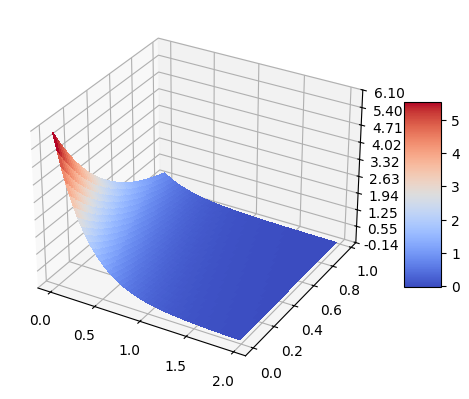

In [9]:
#plot

import torch
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

